In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_21_var_3_species.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 3
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(33868, 147, 1)
(8468, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 900,195
Trainable params: 900,195
Non-trainable params: 0
__________________________________________________

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
265/265 - 6s - loss: 1.0421 - accuracy: 0.4385 - 6s/epoch - 24ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.9784 - accuracy: 0.4950
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.9805 - accuracy: 0.4932

Epoch:  2
265/265 - 5s - loss: 0.9371 - accuracy: 0.5339 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.8751 - accuracy: 0.5650
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.8826 - accuracy: 0.5596

Epoch:  3
265/265 - 5s - loss: 0.8072 - accuracy: 0.6428 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.7296 - accuracy: 0.6754
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.7433 - accuracy: 0.6673

Epoch:  4
265/265 - 5s - loss: 0.6278 - accuracy: 0.7556 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 

1059/1059 [==============================] - 4s 4ms/step - loss: 0.1541 - accuracy: 0.9432
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.1655 - accuracy: 0.9387

Epoch:  30
265/265 - 5s - loss: 0.1521 - accuracy: 0.9434 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1422 - accuracy: 0.9495
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.1530 - accuracy: 0.9433

Epoch:  31
265/265 - 5s - loss: 0.1516 - accuracy: 0.9431 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1481 - accuracy: 0.9438
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.1587 - accuracy: 0.9386

Epoch:  32
265/265 - 5s - loss: 0.1482 - accuracy: 0.9462 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.1494 - accuracy: 0.9426
for testing
265/265 [===========================

265/265 [==============================] - 1s 4ms/step - loss: 0.0991 - accuracy: 0.9652

Epoch:  58
265/265 - 5s - loss: 0.0986 - accuracy: 0.9649 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0946 - accuracy: 0.9646
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.1049 - accuracy: 0.9610

Epoch:  59
265/265 - 5s - loss: 0.0931 - accuracy: 0.9672 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0890 - accuracy: 0.9680
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0967 - accuracy: 0.9652

Epoch:  60
265/265 - 5s - loss: 0.0917 - accuracy: 0.9680 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0860 - accuracy: 0.9690
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0953 - accuracy: 0.9671

Epoch:  61
265/265 - 5s - loss: 0.0903 - accuracy

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0538 - accuracy: 0.9805
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0604 - accuracy: 0.9787

Epoch:  87
265/265 - 5s - loss: 0.0565 - accuracy: 0.9799 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0513 - accuracy: 0.9817
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0586 - accuracy: 0.9797

Epoch:  88
265/265 - 5s - loss: 0.0565 - accuracy: 0.9795 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0510 - accuracy: 0.9820
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0563 - accuracy: 0.9802

Epoch:  89
265/265 - 5s - loss: 0.0531 - accuracy: 0.9813 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0495 - accuracy: 0.9822
for testing
265/265 [==============

265/265 [==============================] - 1s 4ms/step - loss: 0.0552 - accuracy: 0.9798

Epoch:  115
265/265 - 5s - loss: 0.0472 - accuracy: 0.9824 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0520 - accuracy: 0.9808
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0592 - accuracy: 0.9792

Epoch:  116
265/265 - 5s - loss: 0.0489 - accuracy: 0.9823 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0404 - accuracy: 0.9857
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0460 - accuracy: 0.9843

Epoch:  117
265/265 - 5s - loss: 0.0439 - accuracy: 0.9837 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0421 - accuracy: 0.9851
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0484 - accuracy: 0.9831

Epoch:  118
265/265 - 5s - loss: 0.0448 - accu

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0316 - accuracy: 0.9884
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0368 - accuracy: 0.9876

Epoch:  144
265/265 - 5s - loss: 0.0350 - accuracy: 0.9871 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0301 - accuracy: 0.9893
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0367 - accuracy: 0.9871

Epoch:  145
265/265 - 5s - loss: 0.0387 - accuracy: 0.9858 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0297 - accuracy: 0.9890
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0367 - accuracy: 0.9871

Epoch:  146
265/265 - 5s - loss: 0.0389 - accuracy: 0.9862 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0342 - accuracy: 0.9879
for testing
265/265 [===========

265/265 [==============================] - 1s 4ms/step - loss: 0.0553 - accuracy: 0.9815

Epoch:  172
265/265 - 5s - loss: 0.0343 - accuracy: 0.9875 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0255 - accuracy: 0.9915
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0332 - accuracy: 0.9895

Epoch:  173
265/265 - 5s - loss: 0.0326 - accuracy: 0.9879 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0286 - accuracy: 0.9900
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0356 - accuracy: 0.9875

Epoch:  174
265/265 - 5s - loss: 0.0304 - accuracy: 0.9893 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0360 - accuracy: 0.9863
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0420 - accuracy: 0.9857

Epoch:  175
265/265 - 5s - loss: 0.0345 - accu

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0240 - accuracy: 0.9904
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0315 - accuracy: 0.9889

Epoch:  201
265/265 - 5s - loss: 0.0318 - accuracy: 0.9880 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0248 - accuracy: 0.9912
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0312 - accuracy: 0.9895

Epoch:  202
265/265 - 5s - loss: 0.0272 - accuracy: 0.9900 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0413 - accuracy: 0.9842
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0486 - accuracy: 0.9836

Epoch:  203
265/265 - 5s - loss: 0.0300 - accuracy: 0.9886 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0310 - accuracy: 0.9887
for testing
265/265 [===========

265/265 [==============================] - 1s 4ms/step - loss: 0.0292 - accuracy: 0.9901

Epoch:  229
265/265 - 5s - loss: 0.0268 - accuracy: 0.9900 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0209 - accuracy: 0.9925
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0282 - accuracy: 0.9910

Epoch:  230
265/265 - 5s - loss: 0.0300 - accuracy: 0.9888 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0283 - accuracy: 0.9898
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0336 - accuracy: 0.9889

Epoch:  231
265/265 - 5s - loss: 0.0277 - accuracy: 0.9898 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0266 - accuracy: 0.9903
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0333 - accuracy: 0.9898

Epoch:  232
265/265 - 5s - loss: 0.0283 - accu

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0179 - accuracy: 0.9937
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0244 - accuracy: 0.9919

Epoch:  258
265/265 - 5s - loss: 0.0256 - accuracy: 0.9906 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0279 - accuracy: 0.9901
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0357 - accuracy: 0.9878

Epoch:  259
265/265 - 5s - loss: 0.0253 - accuracy: 0.9909 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0190 - accuracy: 0.9933
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0268 - accuracy: 0.9916

Epoch:  260
265/265 - 6s - loss: 0.0217 - accuracy: 0.9923 - 6s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0203 - accuracy: 0.9922
for testing
265/265 [===========

265/265 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.9921

Epoch:  286
265/265 - 5s - loss: 0.0222 - accuracy: 0.9919 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0168 - accuracy: 0.9950
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0237 - accuracy: 0.9916

Epoch:  287
265/265 - 5s - loss: 0.0222 - accuracy: 0.9924 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0163 - accuracy: 0.9941
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0237 - accuracy: 0.9920

Epoch:  288
265/265 - 5s - loss: 0.0199 - accuracy: 0.9931 - 5s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0189 - accuracy: 0.9937
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.9910

Epoch:  289
265/265 - 5s - loss: 0.0226 - accu

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0202 - accuracy: 0.9926
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0282 - accuracy: 0.9897

Epoch:  315
265/265 - 5s - loss: 0.0211 - accuracy: 0.9923 - 5s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0212 - accuracy: 0.9927
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0289 - accuracy: 0.9904

Epoch:  316
265/265 - 5s - loss: 0.0215 - accuracy: 0.9922 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0185 - accuracy: 0.9939
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0286 - accuracy: 0.9907

Epoch:  317
265/265 - 5s - loss: 0.0201 - accuracy: 0.9928 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0166 - accuracy: 0.9942
for testing
265/265 [===========

265/265 [==============================] - 1s 4ms/step - loss: 0.0300 - accuracy: 0.9898

Epoch:  343
265/265 - 5s - loss: 0.0184 - accuracy: 0.9932 - 5s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0132 - accuracy: 0.9958
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0215 - accuracy: 0.9928

Epoch:  344
265/265 - 5s - loss: 0.0196 - accuracy: 0.9926 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0128 - accuracy: 0.9958
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0222 - accuracy: 0.9922

Epoch:  345
265/265 - 5s - loss: 0.0201 - accuracy: 0.9929 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0139 - accuracy: 0.9952
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0229 - accuracy: 0.9927

Epoch:  346
265/265 - 6s - loss: 0.0178 - accu

for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0194 - accuracy: 0.9928
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0256 - accuracy: 0.9907

Epoch:  372
265/265 - 5s - loss: 0.0157 - accuracy: 0.9941 - 5s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0135 - accuracy: 0.9953
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0205 - accuracy: 0.9927

Epoch:  373
265/265 - 5s - loss: 0.0171 - accuracy: 0.9940 - 5s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0143 - accuracy: 0.9943
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0236 - accuracy: 0.9926

Epoch:  374
265/265 - 5s - loss: 0.0213 - accuracy: 0.9925 - 5s/epoch - 20ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0202 - accuracy: 0.9926
for testing
265/265 [===========

265/265 [==============================] - 1s 4ms/step - loss: 0.0221 - accuracy: 0.9927

Epoch:  400
265/265 - 6s - loss: 0.0154 - accuracy: 0.9944 - 6s/epoch - 21ms/step
for training
1059/1059 [==============================] - 4s 4ms/step - loss: 0.0190 - accuracy: 0.9924
for testing
265/265 [==============================] - 1s 4ms/step - loss: 0.0289 - accuracy: 0.9901


In [24]:
history_dataframe

,loss,accuracy
0,1.042062,0.438526
1,0.937123,0.533896
2,0.807215,0.642790
3,0.627837,0.755551
4,0.502582,0.801524
...,...,...
395,0.015409,0.994833
396,0.016019,0.994538
397,0.014962,0.994744
398,0.014857,0.994390


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

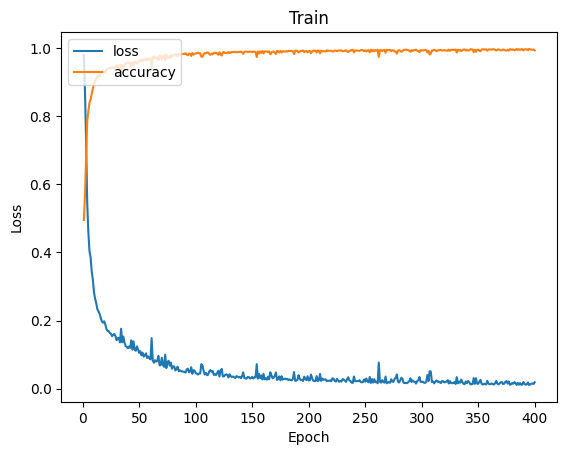

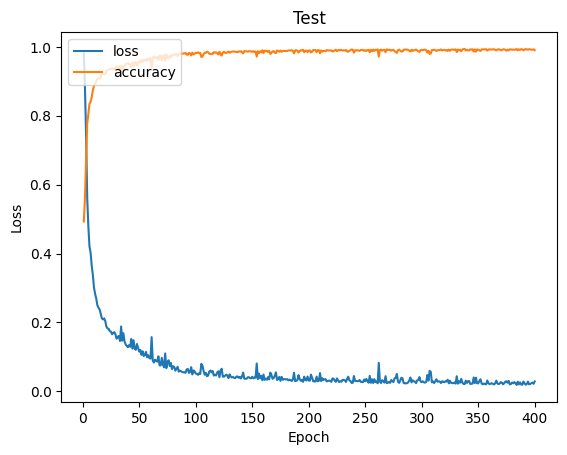

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])